In [333]:
#Imports
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
from cellpose import models, io, core
import matplotlib.pyplot as plt
import math
from u_net import UNet
import torch
from scipy import ndimage
from statistics import mean, median
import seaborn as sns


In [5]:
def get_data(path, num_imgs=4):

    images_path = path + '01/'
    onlyfiles = [f for f in listdir(images_path) if isfile(join(images_path, f))]
    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    images = [np.squeeze(tifffile.imread(images_path +  onlyfiles[i])) for i in range(num_imgs)]
    images = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in images]
    
    masks_path = path + '01_GT/TRA/'
    onlyfiles = [f for f in listdir(masks_path) if isfile(join(masks_path, f))][1:]
    onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]
    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    masks = [np.squeeze(tifffile.imread(masks_path +  onlyfiles[i])) for i in range(num_imgs)]
    #binarise the masks
    #masks = [np.where(mask>0,1,0) for mask in masks]

    return images, masks

In [6]:
#Get cell images #Get cell masks
images, masks = get_data("/Users/rehanzuberi/Downloads/distillCellSegTrack/" + 'datasets/Fluo-N2DL-HeLa/', num_imgs=92)

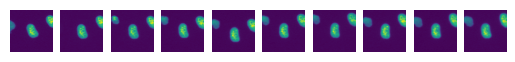

/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_402/210248808.py:24: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(crop)


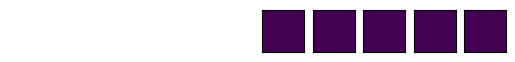

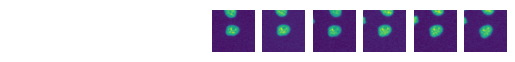

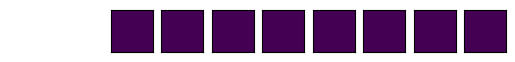

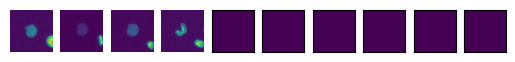

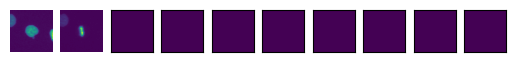

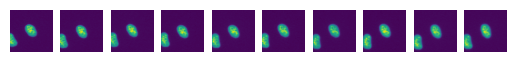

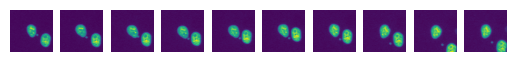

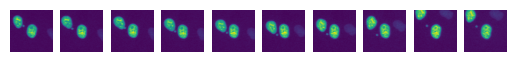

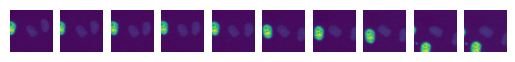

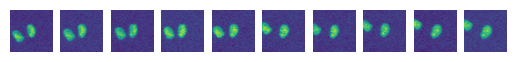

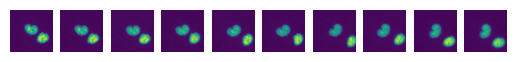

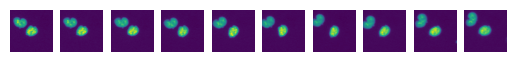

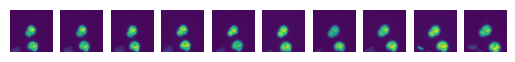

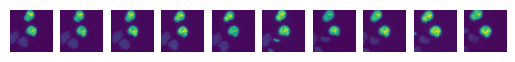

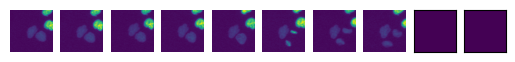

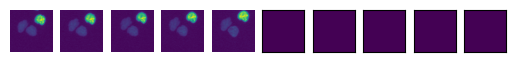

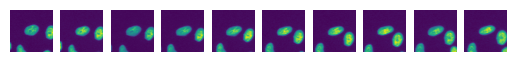

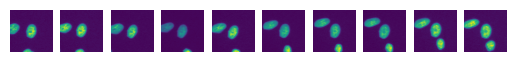

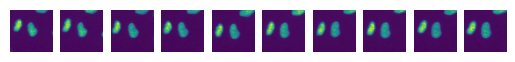

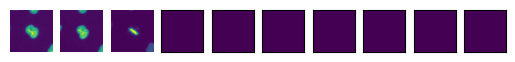

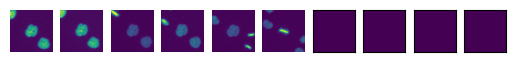

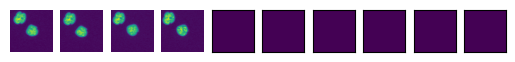

/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_402/210248808.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(crop)


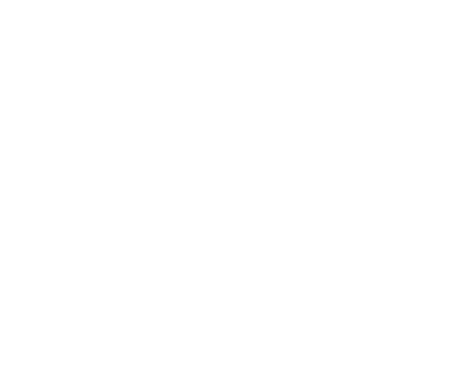

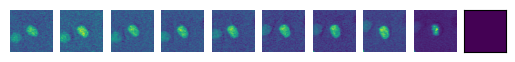

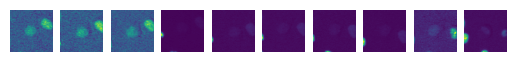

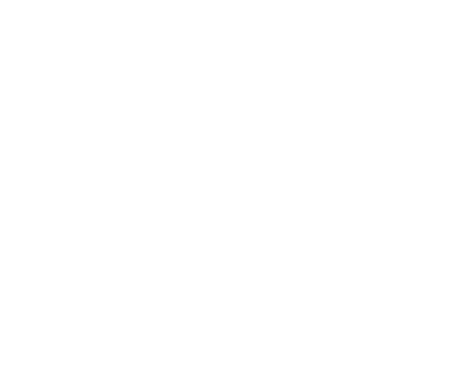

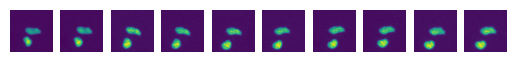

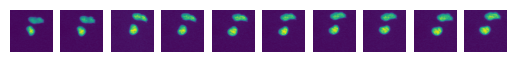

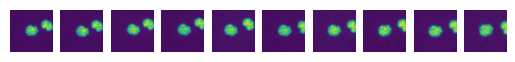

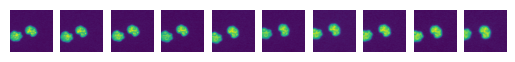

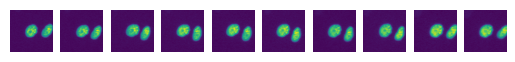

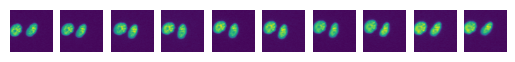

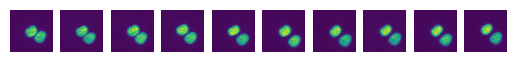

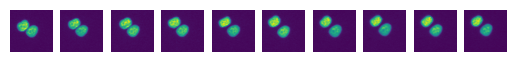

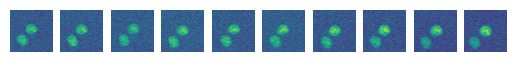

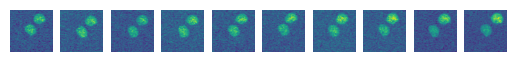

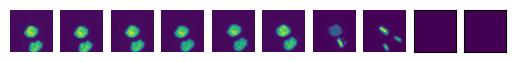

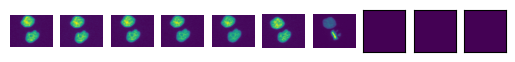

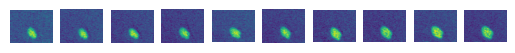

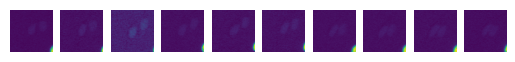

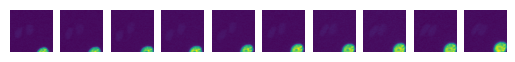

In [29]:
#Plotting matching indices
crop_size = 100

for j in np.unique(masks[0])[1:]:
    for i in range(10):
        plt.subplot(1,10,i+1)
        x, y = np.where(masks[i]==j)
        x = np.mean(x)
        y = np.mean(y)
        if math.isnan(x) or math.isnan(y):
            #crop is empty image of zeros
            crop = np.zeros((crop_size,crop_size))
            plt.xticks([])
            plt.yticks([])
        else:
            crop = images[i][int(x-crop_size/2):int(x+crop_size/2),int(y-crop_size/2):int(y+crop_size/2)]
            plt.axis('off')
        plt.imshow(crop)
    plt.show()

In [94]:
#Import distill model
model = UNet()
#model = model.to('cuda:0')
model.load_state_dict(torch.load('/Users/rehanzuberi/Downloads/distillCellSegTrack/segmentation/train_dir/models/unet_trained_model',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def block_mean(ar, fact, method):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    #res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    if method == 'maximum':
        res = ndimage.maximum(ar, labels=regions, index=np.arange(regions.max() + 1))
    elif method == 'minimum':
        res = ndimage.minimum(ar, labels=regions, index=np.arange(regions.max() + 1))
    elif method == 'median':
        res = ndimage.minimum(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx//fact, sy//fact)
    return res

In [201]:
def get_cell_encodings(encoder,image,mask,downsampling_method='maximum'):
    #Get encoding of image
    image = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)
    encoding = encoder(image)[2].cpu().detach().numpy()[0]

    #Downsample the mask to match the shape of the encoding
    downsampled_mask = block_mean(mask, 4, method=downsampling_method)

    #Mask out the encoder features of each cell
    encodings_cells_per_channel = []
    for j in np.unique(downsampled_mask)[1:]: #64 channels
        encodings_of_cell = []
        for channel_number in range(encoding.shape[0]):
            encodings_of_cell.append(encoding[channel_number][np.where(downsampled_mask==j)])
        encodings_cells_per_channel.append(encodings_of_cell)

    return encodings_cells_per_channel

In [217]:
#Get encoder
encoder = model.encoder
downsampling_method = 'maximum'

#Get encoder features
test_image = images[0]
test_mask = masks[0]
encodings_cells_per_channel_0 = get_cell_encodings(encoder,test_image,test_mask,downsampling_method=downsampling_method)
encodings_cells_per_channel_0 = np.array(encodings_cells_per_channel_0)

test_image = images[1]
test_mask = masks[1]
encodings_cells_per_channel_1 = get_cell_encodings(encoder,test_image,test_mask,downsampling_method=downsampling_method)
encodings_cells_per_channel_1 = np.array(encodings_cells_per_channel_1)


/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_402/1485629339.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encodings_cells_per_channel_0 = np.array(encodings_cells_per_channel_0)
/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_402/1485629339.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encodings_cells_per_channel_1 = np.array(encodings_cells_per_channel_1)


In [281]:
#calculate centers that we will use to define to a distance coefficient (1/distance_between_cells)
centers_0 = []
for i in np.unique(masks[0])[1:]:
    x, y = np.where(masks[0]==i)
    centers_0.append((np.mean(x),np.mean(y)))

#get the centers of every cell in masks[1]
centers_1 = []
for i in np.unique(masks[1])[1:]:
    x, y = np.where(masks[1]==i)
    centers_1.append((np.mean(x),np.mean(y)))

distances = []
for i in range(len(centers_0)):
    distances_per_cell = []
    for j in range(len(centers_1)):
        distances_per_cell.append(math.sqrt((centers_1[j][0]-centers_0[i][0])**2 + (centers_1[j][1]-centers_0[i][1])**2))
    distances.append(distances_per_cell)

In [446]:
#calculate difference in cell sizes to define a size coefficient (1/difference_in_cell_sizes)

#for i in np.unique(masks[0])[1:]:
lenghts_of_cells_0 = np.unique(masks[0],return_counts=True)[1][1:]
lengths_of_cells_1 = np.unique(masks[1],return_counts=True)[1][1:]
#get the difference between every values
size_difference = []
for i in lenghts_of_cells_0:
    size_differences_per_cell = []
    for j in lengths_of_cells_1:
        size_differences_per_cell.append(abs(i-j))
    size_difference.append(size_differences_per_cell)

print(size_difference)

[[55, 344, 142, 76, 90, 59, 258, 48, 140, 11, 104, 169, 9, 140, 144, 196, 280, 196, 18, 13, 10, 84, 84, 196, 196, 140, 244, 320, 196, 280, 196, 244, 196, 244, 140, 244, 244, 218, 140, 65, 280, 320, 320], [289, 0, 202, 268, 434, 403, 86, 296, 204, 355, 240, 175, 335, 204, 200, 148, 64, 148, 326, 357, 334, 260, 260, 148, 148, 204, 100, 24, 148, 64, 148, 100, 148, 100, 204, 100, 100, 126, 204, 279, 64, 24, 24], [121, 168, 34, 100, 266, 235, 82, 128, 36, 187, 72, 7, 167, 36, 32, 20, 104, 20, 158, 189, 166, 92, 92, 20, 20, 36, 68, 144, 20, 104, 20, 68, 20, 68, 36, 68, 68, 42, 36, 111, 104, 144, 144], [85, 204, 2, 64, 230, 199, 118, 92, 0, 151, 36, 29, 131, 0, 4, 56, 140, 56, 122, 153, 130, 56, 56, 56, 56, 0, 104, 180, 56, 140, 56, 104, 56, 104, 0, 104, 104, 78, 0, 75, 140, 180, 180], [145, 434, 232, 166, 0, 31, 348, 138, 230, 79, 194, 259, 99, 230, 234, 286, 370, 286, 108, 77, 100, 174, 174, 286, 286, 230, 334, 410, 286, 370, 286, 334, 286, 334, 230, 334, 334, 308, 230, 155, 370, 410, 410],

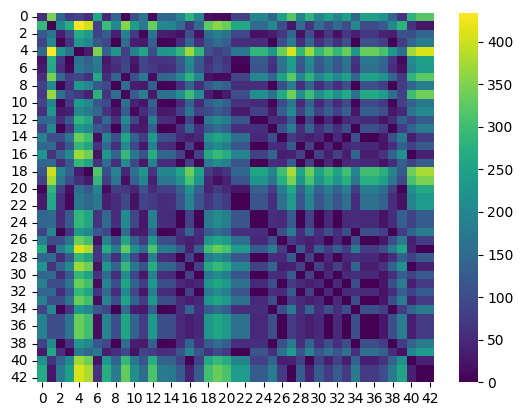

In [447]:
#heatmap of size differences
sns.heatmap(size_difference, cmap='viridis'); plt.show()

In [282]:
print(len(encodings_cells_per_channel_0))
print(len(encodings_cells_per_channel_1))
print(len(distances))

43
43
43


In [323]:
from scipy import spatial

def calculate_cosine_distance(a, b):
    cosine_distance = float(spatial.distance.cosine(a, b))
    return cosine_distance

def calculate_cosine_similarity(a, b):
    cosine_similarity = 1 - calculate_cosine_distance(a, b)
    return cosine_similarity

def calculate_angular_distance(a, b):
    cosine_similarity = calculate_cosine_similarity(a, b)
    angular_distance = math.acos(cosine_similarity) / math.pi
    return angular_distance

In [458]:
#for now just get the cos_sim between two of them
from scipy import spatial

def get_cos_sims_between_images(encodings_cells_per_channel_0,encodings_cells_per_channel_1, padding_method='mean'):
    cosine_similarities_between_images = []

    for k in range(len(encodings_cells_per_channel_0)):

        cosine_similarities_per_cell = []

        for j in range(len(encodings_cells_per_channel_1)):
            cosine_similarities = []
            #if distances[k][j] > 1000:
            #    cosine_similarities_per_cell.append(0)
            #    continue
            #else:
            for i in range(64):
                arr1 = encodings_cells_per_channel_0[k][i]
                arr2 = encodings_cells_per_channel_1[j][i]

                if len(arr1) > len(arr2):
                    arr2 = np.pad(arr2, (0, arr1.shape[0]-arr2.shape[0]), padding_method)
                elif len(arr1) < len(arr2):
                    arr1 = np.pad(arr1, (0, arr2.shape[0]-arr1.shape[0]), padding_method)

                cos_sim = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))
                #cos_sim = 1 - calculate_angular_distance(arr1, arr2)
                cosine_similarities.append(cos_sim)

            mean_cosine_similarity = mean(cosine_similarities)
            distance_coeff = 1/(distances[k][j]) if distances[k][j] != 0 else 1
            size_coeff = 1/(size_difference[k][j])
            similarity_coeff = mean_cosine_similarity + distance_coeff + size_coeff*0.1
            cosine_similarities_per_cell.append(similarity_coeff)

        cosine_similarities_between_images.append(cosine_similarities_per_cell)
    
    cosine_similarities_between_images = np.array(cosine_similarities_between_images)

    return cosine_similarities_between_images

In [459]:
cosine_similarities_between_images_mean = get_cos_sims_between_images(encodings_cells_per_channel_0,encodings_cells_per_channel_1,padding_method='mean')

/var/folders/ff/h7rcmtgd7cd83fyvtv05xp5m0000gn/T/ipykernel_402/3421210097.py:32: RuntimeWarning: divide by zero encountered in long_scalars
  size_coeff = 1/(size_difference[k][j])


In [460]:
#calculate accuracy by the percentage of pairs that have the same value for both elements
pairs = []
length = min(len(cosine_similarities_between_images_mean),len(cosine_similarities_between_images_mean[0]))
cos_sims_lst = np.array(cosine_similarities_between_images_mean)
for i in range(length):
    max_index = np.argmax(cos_sims_lst)
    row, col = np.unravel_index(max_index, cos_sims_lst.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
    cos_sims_lst[:,col] = -10
    cos_sims_lst[row,:] = -10
correct_pairs = 0
for pair in pairs:
    if pair[0] == pair[1]:
        correct_pairs += 1
accuracy = correct_pairs/len(np.unique(masks[0])[1:])
print(accuracy)

0.4418604651162791


In [426]:
print(len(cosine_similarities_between_images_mean),len(cosine_similarities_between_images_mean[0]))

43 43


In [424]:
print(len(np.unique(masks[0])[1:]))

43


In [428]:
print(len(pairs))
print(correct_pairs)

43
41


In [454]:
for pair in pairs:
    if pair[0] != pair[1]:
        print(pair)

(3, 8)
(6, 21)
(8, 13)
(12, 15)
(13, 25)
(14, 26)
(15, 17)
(17, 23)
(21, 22)
(23, 24)
(24, 28)
(25, 34)
(26, 31)
(28, 30)
(30, 32)
(31, 33)
(33, 35)
(34, 38)
(35, 36)
(5, 3)
(10, 14)
(18, 5)
(38, 2)
(32, 6)
(22, 12)
(11, 18)
(2, 11)
(36, 10)


In [461]:
print(np.unique(masks[0],return_counts=True)[1][26])
print(np.unique(masks[1],return_counts=True)[1][26])

print(np.unique(masks[0],return_counts=True)[1][36])
print(np.unique(masks[1],return_counts=True)[1][36])


249
249
145
145


In [ ]:
arr1 = encodings_cells_per_channel_0[0][26]
arr2 = encodings_cells_per_channel_1[1][i]

if len(arr1) > len(arr2):
    arr2 = np.pad(arr2, (0, arr1.shape[0]-arr2.shape[0]), padding_method)
elif len(arr1) < len(arr2):
    arr1 = np.pad(arr1, (0, arr2.shape[0]-arr1.shape[0]), padding_method)

cos_sim = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))

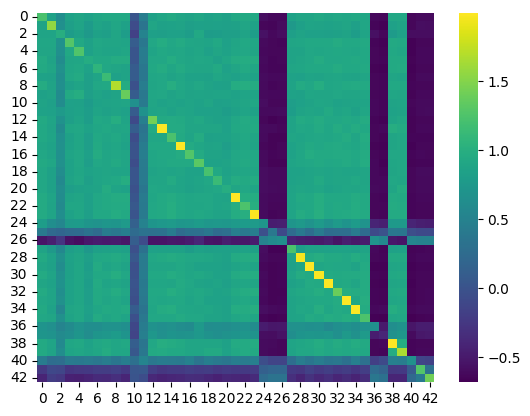

In [395]:
sns.heatmap(cosine_similarities_between_images_mean, cmap='viridis'); plt.show()

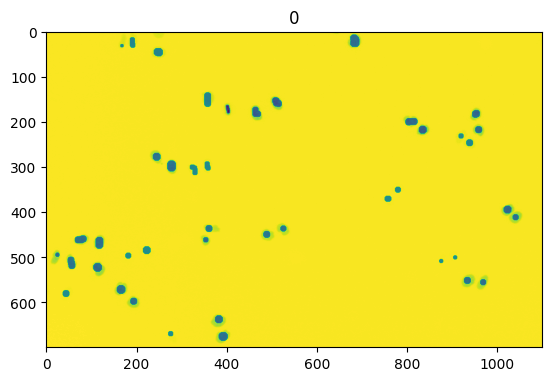

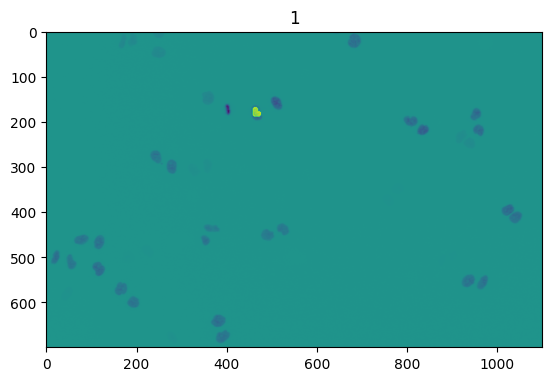

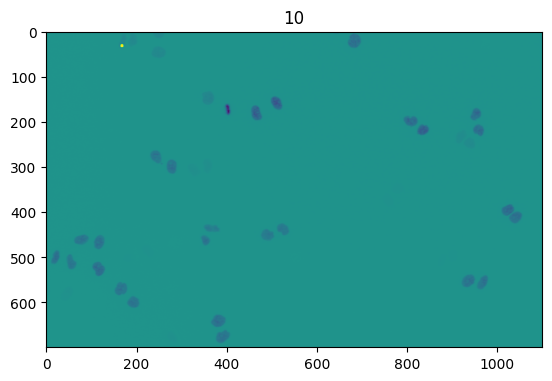

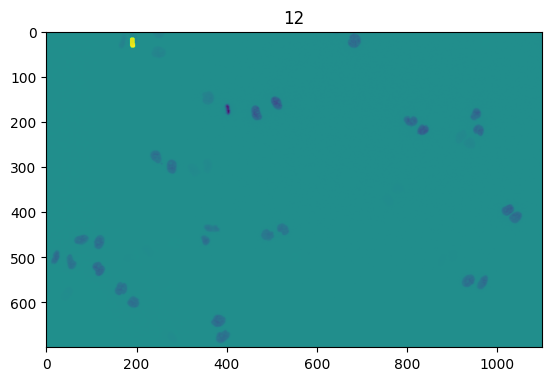

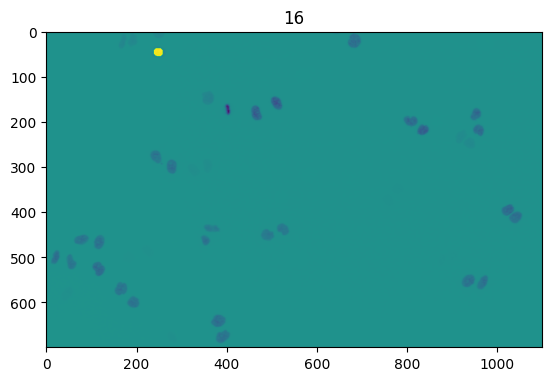

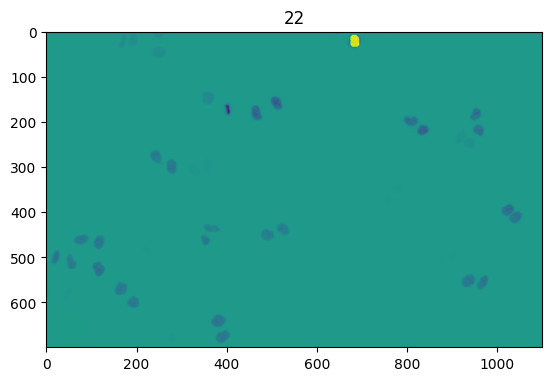

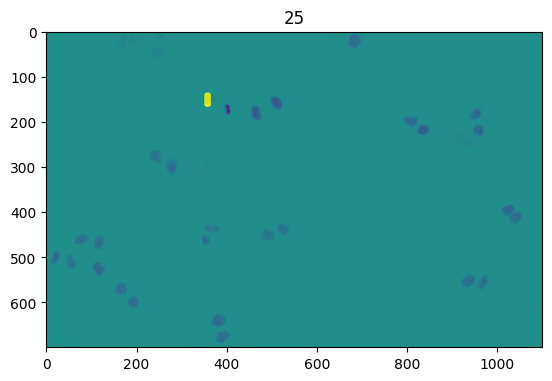

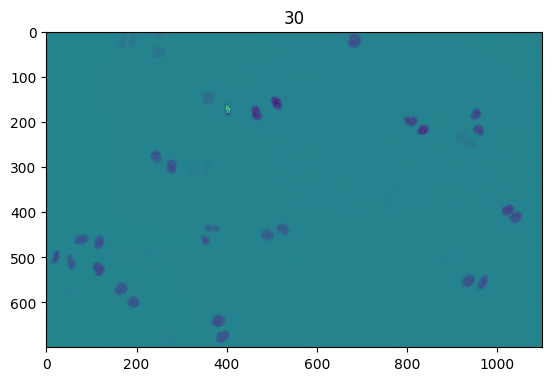

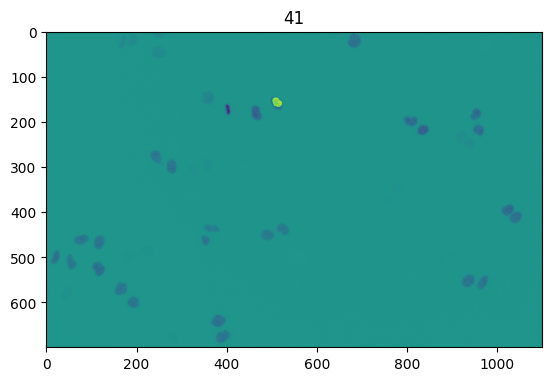

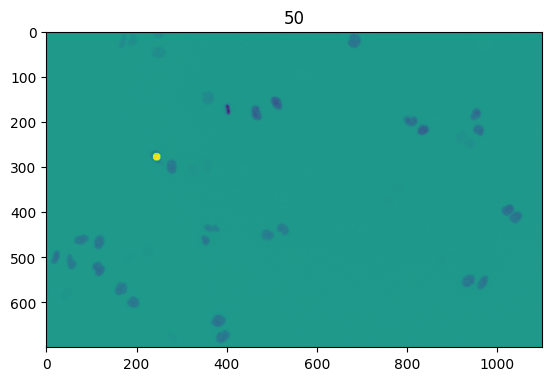

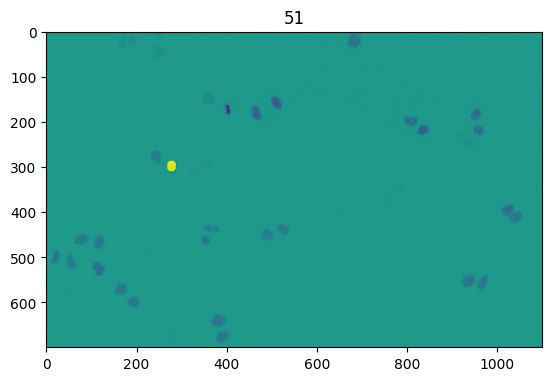

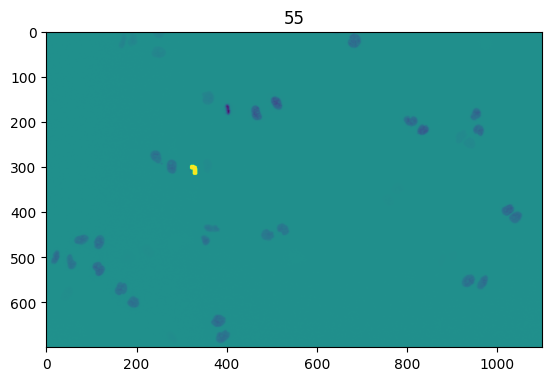

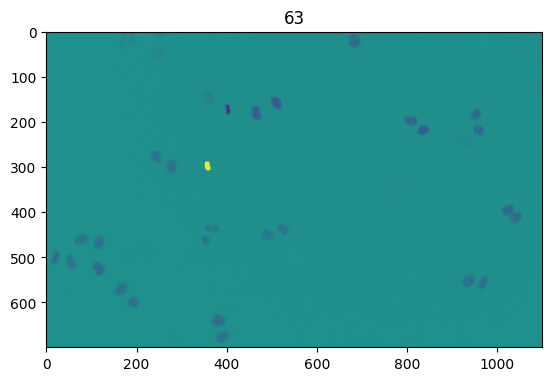

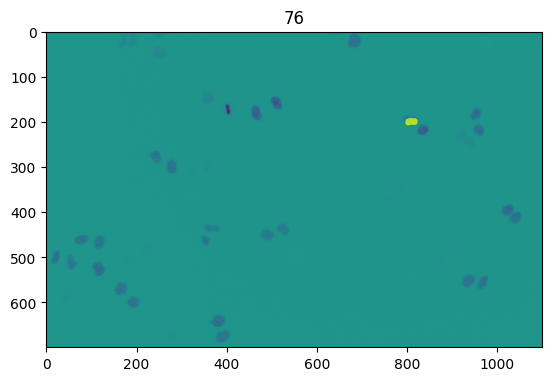

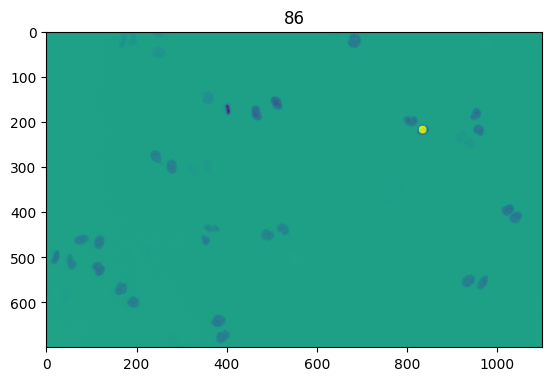

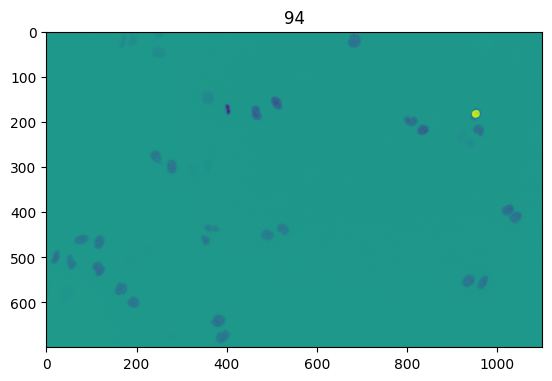

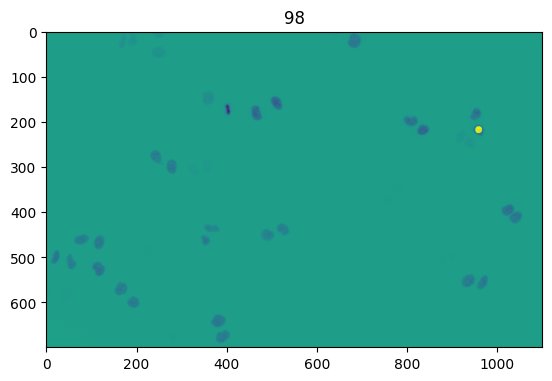

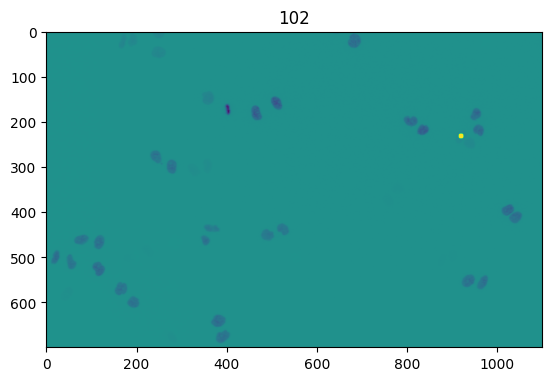

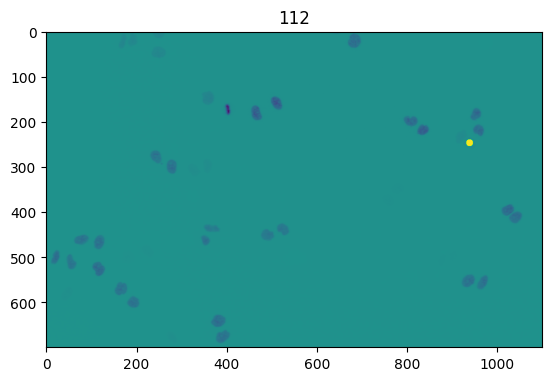

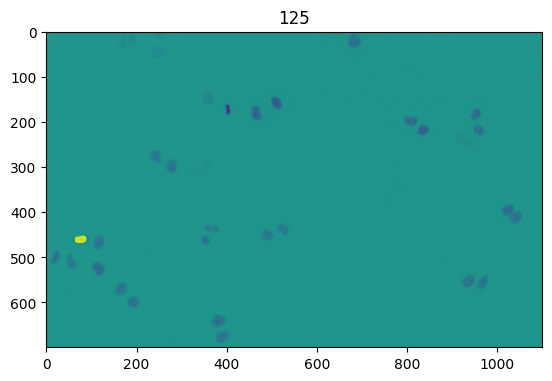

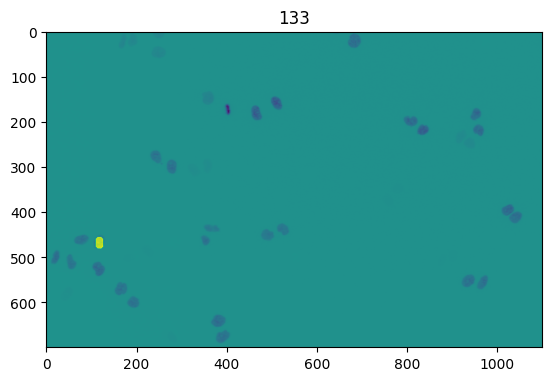

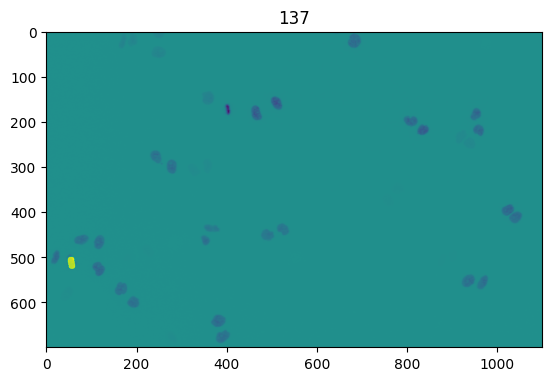

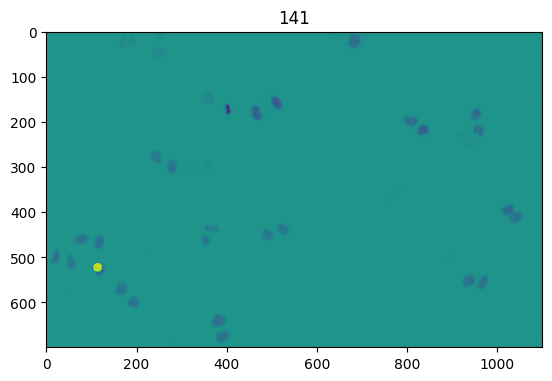

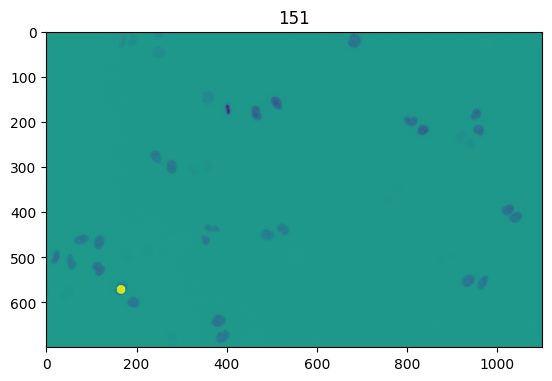

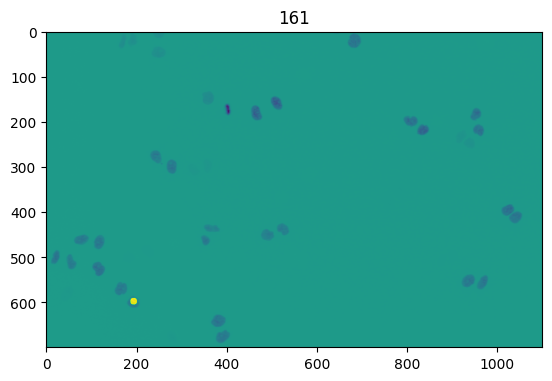

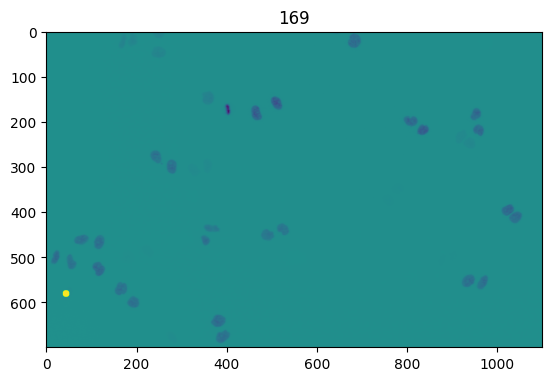

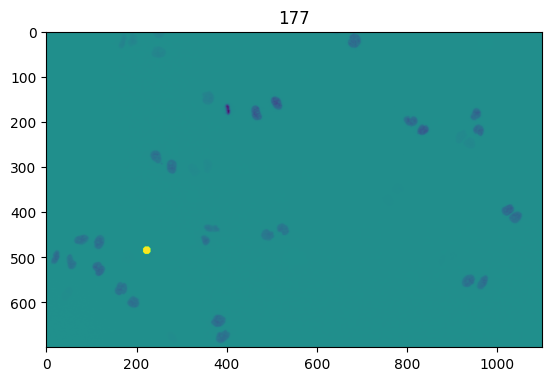

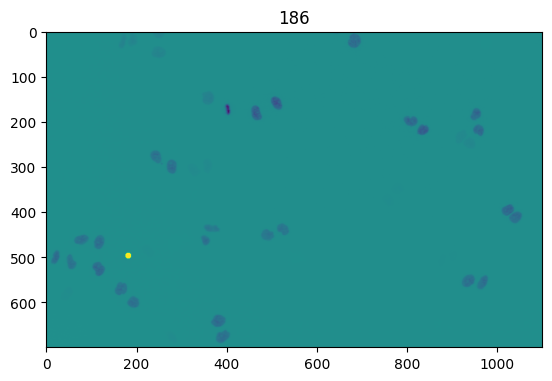

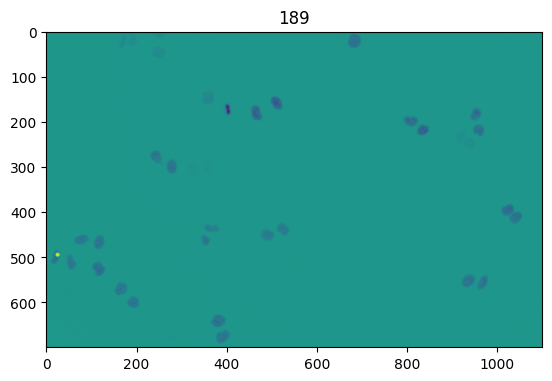

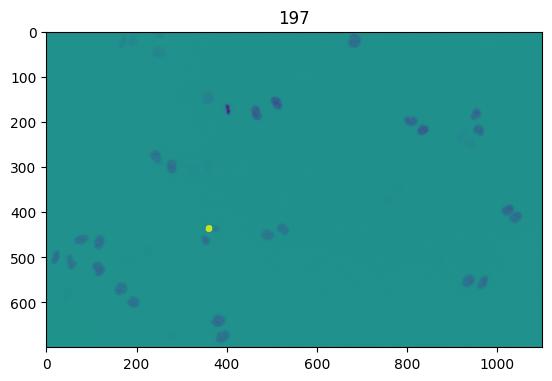

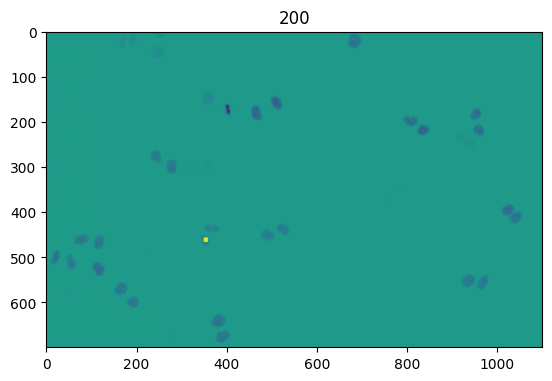

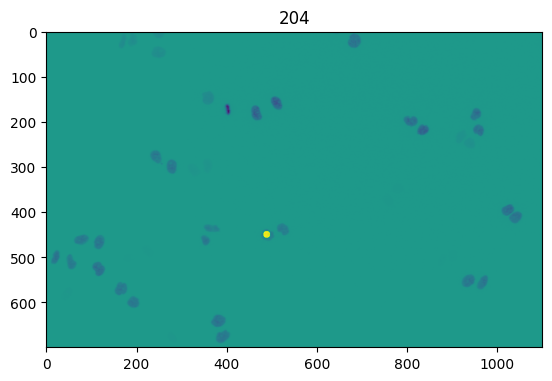

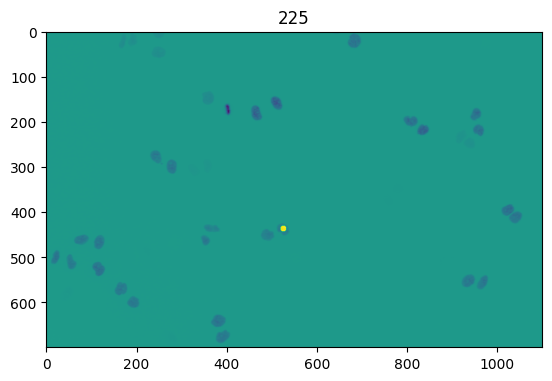

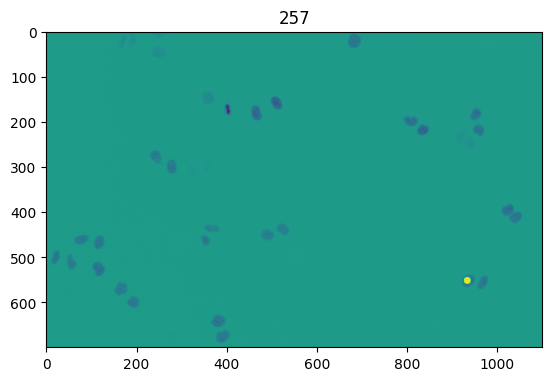

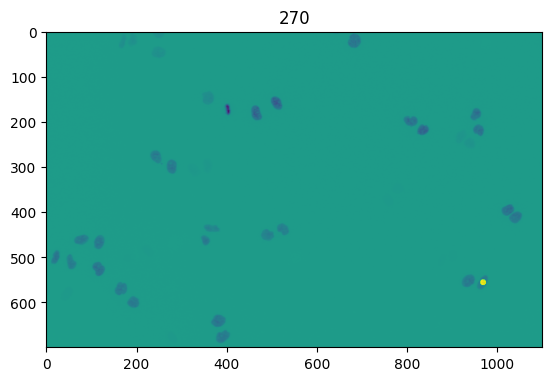

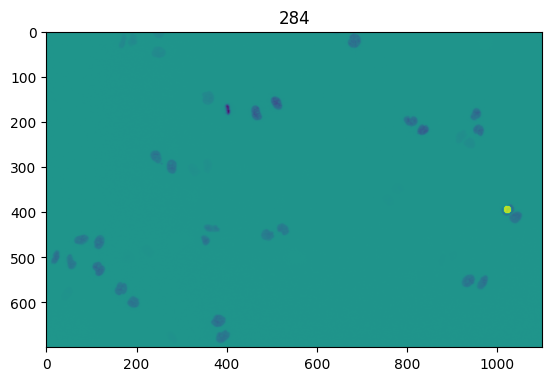

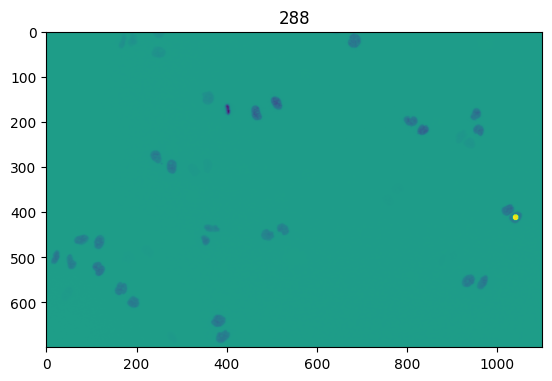

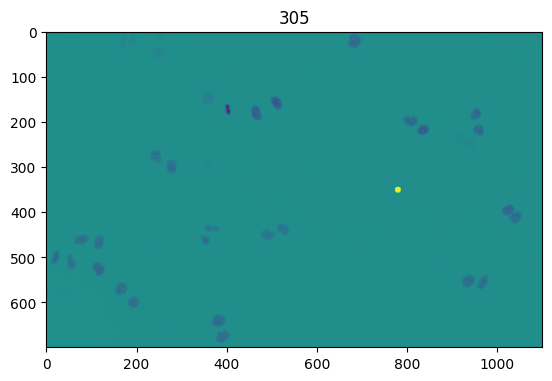

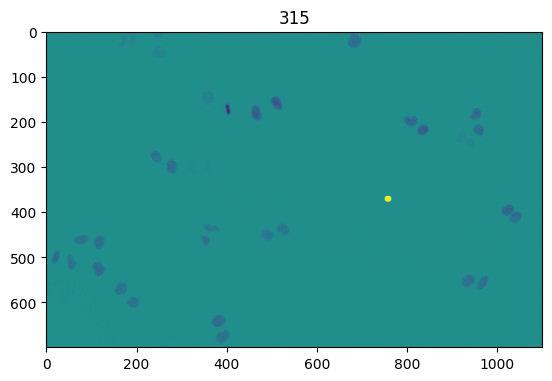

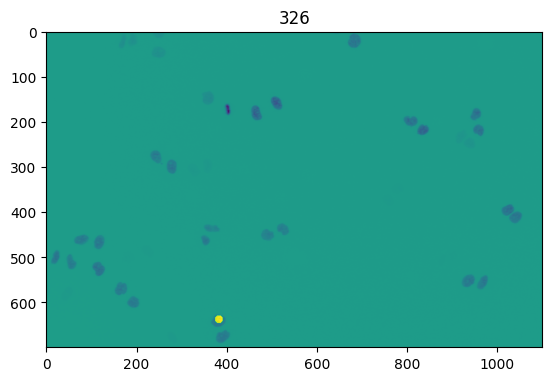

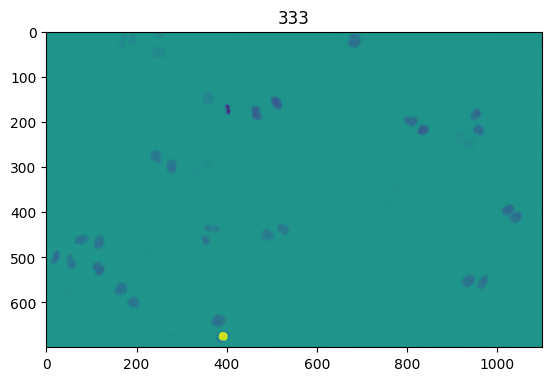

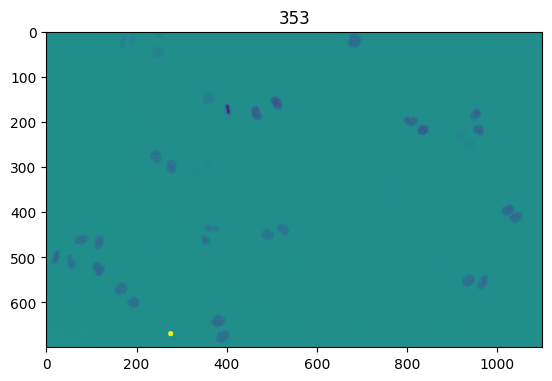

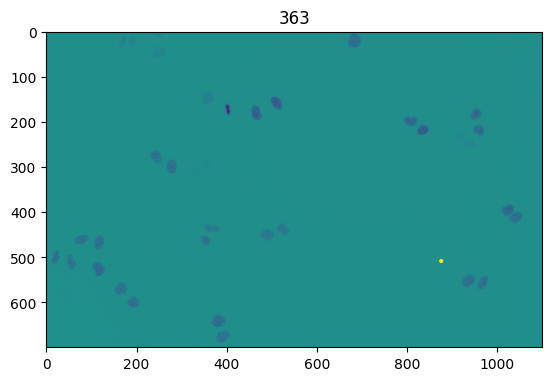

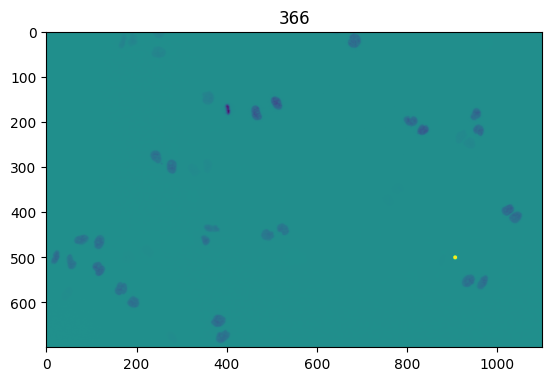

In [421]:
for i in np.unique(masks[1]):
    plt.title(i)
    plt.imshow(np.where(masks[1]==i,1,0)-images[1])

    plt.show()

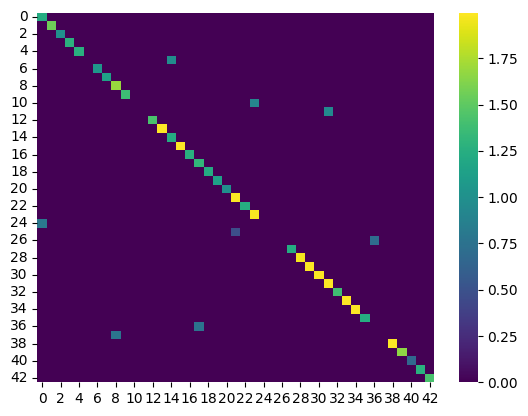

In [396]:
#take cosine_similarities_between_images and for each row get the index of the max value and only keep the value at that index and make all others 0s
max_indexes = []
for i in range(cosine_similarities_between_images_mean.shape[0]):
    max_indexes.append(np.argmax(cosine_similarities_between_images_mean[i]))
cosine_similarities_between_images_max = np.zeros(cosine_similarities_between_images_mean.shape)
for i in range(cosine_similarities_between_images_mean.shape[0]):
    cosine_similarities_between_images_max[i][max_indexes[i]] = cosine_similarities_between_images_mean[i][max_indexes[i]]
sns.heatmap(cosine_similarities_between_images_max, cmap='viridis'); plt.show()

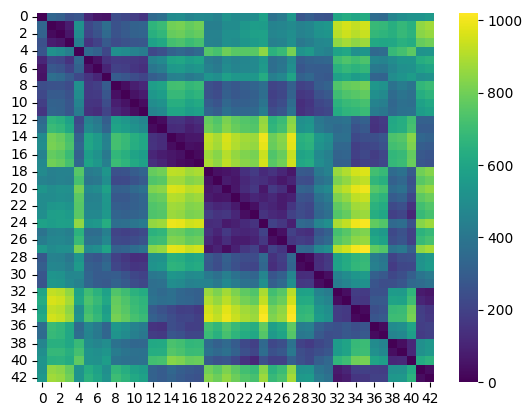

In [243]:
#get the centers of every cell in masks[0]
centers_0 = []
for i in np.unique(masks[0])[1:]:
    x, y = np.where(masks[0]==i)
    centers_0.append((np.mean(x),np.mean(y)))

#get the centers of every cell in masks[1]
centers_1 = []
for i in np.unique(masks[1])[1:]:
    x, y = np.where(masks[1]==i)
    centers_1.append((np.mean(x),np.mean(y)))

#calculate the distance between every pair of centers
distances = []
for i in range(len(centers_0)):
    distances_per_cell = []
    for j in range(len(centers_1)):
        distance = math.sqrt((centers_1[j][0]-centers_0[i][0])**2 + (centers_1[j][1]-centers_0[i][1])**2)
        distances_per_cell.append(math.sqrt((centers_1[j][0]-centers_0[i][0])**2 + (centers_1[j][1]-centers_0[i][1])**2))

    distances.append(distances_per_cell)
#heatmap plot of distances
sns.heatmap(np.array(distances), cmap='viridis'); plt.show()

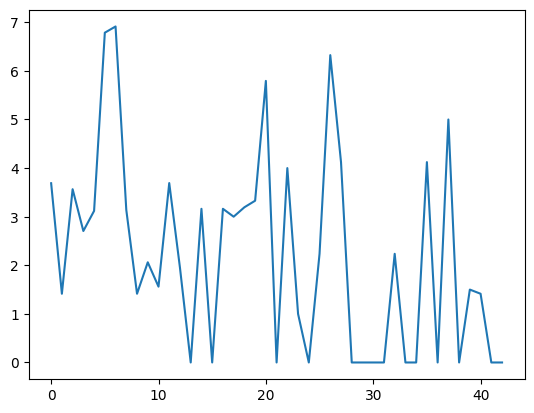

In [301]:
pairs_distances = [] #append the distances of the correct pairs
for i in range(len(distances)):
    pairs_distances.append(distances[i][i])
plt.plot(range(len(pairs_distances)), pairs_distances); plt.show()

In [233]:
print(distances[0][0])
print(distances[1][1])
print(distances[2][2])

0.1270064989009833
3.6885091466822897
nan


In [128]:
#Get the cosine similarity between the corresponding channels of encoding features between cells
#BONUS: display the grid

cos_sims_for_each_cell = []
for cell_encFeats in encodings_cells_per_channel_0:
    cos_sims_for_cell = []
    arr1 = cell_encFeats.flatten()
    for cell_encFeats2 in encodings_cells_per_channel_1:
        arr2 = cell_encFeats2.flatten()
        #if the length difference between arr1 and arr2 is over 25%, cos_sim == 0
        if abs(arr1.shape[0] - arr2.shape[0]) > 0.1 * max(arr1.shape[0], arr2.shape[0]):
            cos_sims_for_cell.append(0)
            continue

        #get the mean of each array
        #arr1_mean = np.mean(arr1)
        #arr2_mean = np.mean(arr2)
        #cos_sims_for_cell.append(abs(arr1_mean - arr2_mean)) #append the absolute value of the difference between the two means
        
    
        #pad the shorter array with the mean of the array
        print(arr1.shape, arr2.shape)
        if arr1.shape[0] > arr2.shape[0]:
            pad_by = arr1.shape[0]-arr2.shape[0]
            arr2 = np.pad(arr2, (0, pad_by), 'constant')
            #arr2 = np.pad(arr2, (0, arr1.shape[0] - arr2.shape[0]), 'mean')
            #arr1 = arr1[:arr2.shape[0]]
        elif arr1.shape[0] < arr2.shape[0]:
            arr2 = arr2[:arr1.shape[0]]
            #arr1 = np.pad(arr1, (0, arr2.shape[0] - arr1.shape[0]), 'mean')
            #arr2 = arr2[:arr1.shape[0]]
        cos_sim = np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))
        cos_sims_for_cell.append(cos_sim)

    cos_sims_for_each_cell.append(cos_sims_for_cell)

cos_sims_for_each_cell = np.array(cos_sims_for_each_cell)

lst = cos_sims_for_each_cell.tolist()


#Average out the cosine similarity to get a single number between every cell between two images

(64,) (64,)


ValueError: operands could not be broadcast together with shapes (34,) (29,) 

In [ ]:
#Use the grid algorithm to match the cells between the two images

In [ ]:
#Compare the found indices to the groundtruth indices